In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the data &inspect data
data = pd.read_csv('/content/drive/MyDrive/Skripsi_Aji Rahman Hakim/Data/undersampled_data.csv')
data.head()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Label
0,0.15,0.03,1.04,-0.09,-0.04,-0.03,Ban Belakang Kempes
1,0.16,0.05,1.03,-0.09,0.00,-0.03,Ban Belakang Kempes
2,0.15,0.03,1.03,-0.09,0.02,-0.02,Ban Belakang Kempes
3,0.12,0.03,1.03,-0.09,0.00,-0.02,Ban Belakang Kempes
4,0.14,0.03,1.04,-0.09,-0.03,-0.03,Ban Belakang Kempes


In [ ]:
# Encode labels
le = LabelEncoder()
data['label_encoded'] = le.fit_transform(data['Label'])

In [ ]:
def split_into_segments(df, segment_length=5, sampling_rate=0.1, step=1):
    samples_per_segment = int(segment_length / sampling_rate)
    segments = []
    labels = []

    for start in range(0, len(df) - samples_per_segment, step):  # Sliding window 10 sampel
        end = start + samples_per_segment
        segment = df.iloc[start:end]

        if len(segment) == samples_per_segment:
            label_mode = segment['label_encoded'].mode()[0]
            if len(segment['label_encoded'].unique()) == 1:  # Pastikan hanya ada satu label dalam segmen
                segments.append(segment[['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']].values)
                labels.append(label_mode)
            else:
                continue  # Lanjutkan ke window berikutnya jika label lebih dari satu

    return np.array(segments), np.array(labels)


In [ ]:
# Membagi data menjadi segmen-segmen
X, y = split_into_segments(data)

In [ ]:
# One-hot encoding for labels
y = to_categorical(y, num_classes=4)

In [ ]:
# Splitting data into training and testing using stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

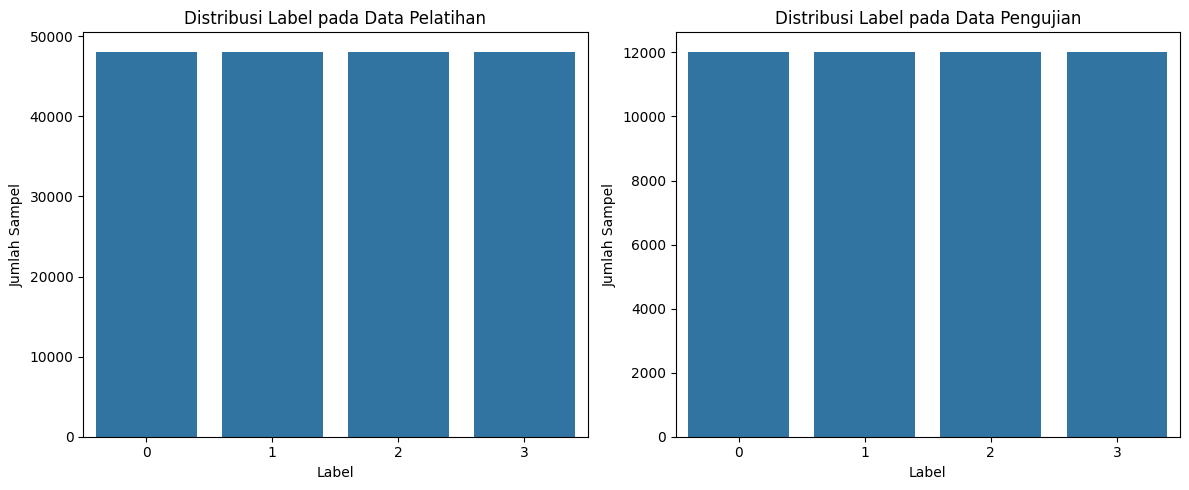

In [ ]:


# Menghitung jumlah sampel per label di data pelatihan
unique_train, counts_train = np.unique(np.argmax(y_train, axis=1), return_counts=True)

# Menghitung jumlah sampel per label di data pengujian
unique_test, counts_test = np.unique(np.argmax(y_test, axis=1), return_counts=True)

# Membuat plot distribusi label
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=unique_train, y=counts_train, ax=ax[0])
ax[0].set_title('Distribusi Label pada Data Pelatihan')
ax[0].set_xlabel('Label')
ax[0].set_ylabel('Jumlah Sampel')

sns.barplot(x=unique_test, y=counts_test, ax=ax[1])
ax[1].set_title('Distribusi Label pada Data Pengujian')
ax[1].set_xlabel('Label')
ax[1].set_ylabel('Jumlah Sampel')

plt.tight_layout()
plt.show()


In [ ]:
# Creating the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.2))

In [ ]:
# Second LSTM layer
model.add(LSTM(50, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))

In [ ]:

# Third LSTM layer
model.add(LSTM(25))
model.add(BatchNormalization())
model.add(Dropout(0.2))

In [ ]:
# Adding a Dense output layer
model.add(Dense(4, activation='softmax'))

In [ ]:
# Compiling the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50, 100)           42800     
                                                                 
 batch_normalization_6 (Bat  (None, 50, 100)           400       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_7 (LSTM)               (None, 50, 50)            30200     
                                                                 
 batch_normalization_7 (Bat  (None, 50, 50)            200       
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 50, 50)           

In [ ]:
# Using early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
# Training the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

Epoch 1/10
6013/6013 [==============================] - 662s 109ms/step - loss: 0.9690 - accuracy: 0.5872 - val_loss: 1.0514 - val_accuracy: 0.5852
Epoch 2/10
6013/6013 [==============================] - 691s 115ms/step - loss: 0.5176 - accuracy: 0.8011 - val_loss: 0.5697 - val_accuracy: 0.7761
Epoch 3/10
6013/6013 [==============================] - 646s 108ms/step - loss: 0.3601 - accuracy: 0.8666 - val_loss: 0.5018 - val_accuracy: 0.8302
Epoch 4/10
6013/6013 [==============================] - 685s 114ms/step - loss: 0.2779 - accuracy: 0.8999 - val_loss: 0.3503 - val_accuracy: 0.8682
Epoch 5/10
6013/6013 [==============================] - 641s 107ms/step - loss: 0.2269 - accuracy: 0.9191 - val_loss: 0.2961 - val_accuracy: 0.8970
Epoch 6/10
6013/6013 [==============================] - 682s 113ms/step - loss: 0.1920 - accuracy: 0.9326 - val_loss: 0.2608 - val_accuracy: 0.9167
Epoch 7/10
6013/6013 [==============================] - 680s 113ms/step - loss: 0.1709 - accuracy: 0.9406 - val_

In [ ]:
# Evaluasi model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

1504/1504 [==============================] - 61s 39ms/step


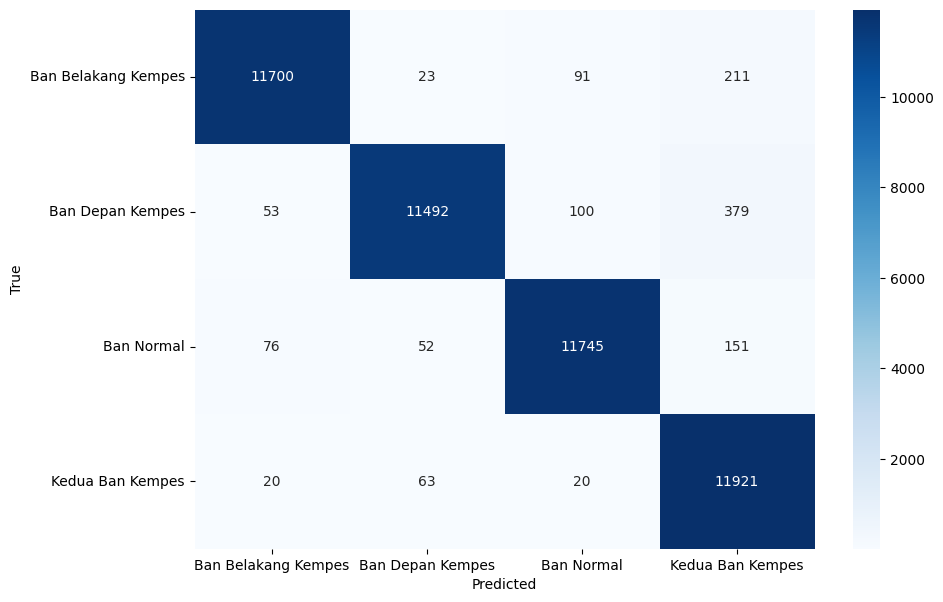

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Classification report
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

                     precision    recall  f1-score   support

Ban Belakang Kempes       0.99      0.97      0.98     12025
   Ban Depan Kempes       0.99      0.96      0.97     12024
         Ban Normal       0.98      0.98      0.98     12024
   Kedua Ban Kempes       0.94      0.99      0.97     12024

           accuracy                           0.97     48097
          macro avg       0.97      0.97      0.97     48097
       weighted avg       0.97      0.97      0.97     48097



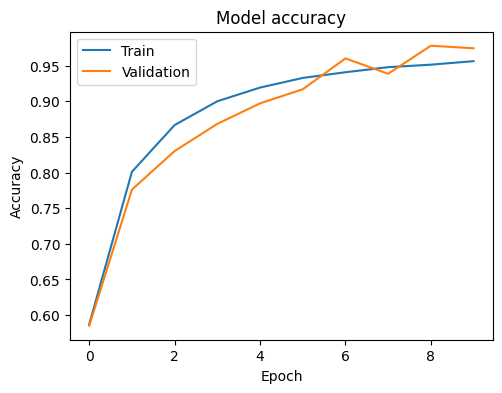

In [ ]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

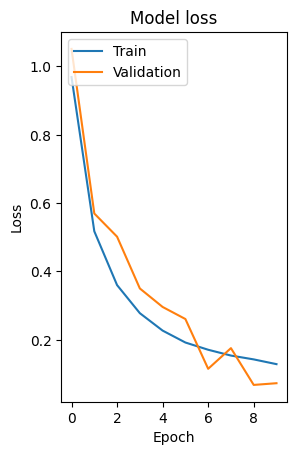

In [ ]:
# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
# Save the model for deployment
model.save('/content/drive/MyDrive/Skripsi_Aji Rahman Hakim/Data/model_shuffle_50-1.keras')

In [ ]:
# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Skripsi_Aji Rahman Hakim/Data/model_shuffle_50-1.keras')

In [ ]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

In [ ]:
# Save the TensorFlow Lite model to a file
with open('/content/drive/MyDrive/Skripsi_Aji Rahman Hakim/Data/model_shuffle_50-1.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model has been converted to TensorFlow Lite and saved.")

Model has been converted to TensorFlow Lite and saved.
